## Predict with pre-trained models
This is a very slightly modified version of the ``Predict with pre-trained models'' example from http://mxnet.io/tutorials/python/predict_imagenet.html.  The only change has been the addition of a function to pull an image from a local directory and also configured so that a gpu is not needed.  

From the MXNet page:
"This is a demo for predicting with a pre-trained model on the full imagenet dataset, which contains over 10 million images and 10 thousands classes. For a more detailed explanation, please refer to predict.ipynb."

This was run using the AWS Machine Learning AMI

First we downloat the model.

In [1]:
import os, urllib
import urllib.request
import mxnet as mx
def download(url,prefix=''):
    filename = prefix+url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

path='http://data.mxnet.io/models/imagenet-11k/'
download(path+'resnet-152/resnet-152-symbol.json', 'full-')
download(path+'resnet-152/resnet-152-0000.params', 'full-')
download(path+'synset.txt', 'full-')


In [2]:
with open('full-synset.txt', 'r') as f:
    synsets = [l.rstrip() for l in f]

sym, arg_params, aux_params = mx.model.load_checkpoint('full-resnet-152', 0)

In [3]:
mod = mx.mod.Module(symbol=sym)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params, aux_params)

/mxnet/python/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

In [16]:
!wget http://4.bp.blogspot.com/-CHRLXChntV4/UBtQLHXwCrI/AAAAAAAANnA/x3cG8Fp9hvo/s1600/Akbash+Dog4.JPG

--2017-11-27 00:55:18--  http://4.bp.blogspot.com/-CHRLXChntV4/UBtQLHXwCrI/AAAAAAAANnA/x3cG8Fp9hvo/s1600/Akbash+Dog4.JPG
Resolving 4.bp.blogspot.com (4.bp.blogspot.com)... 172.217.3.193, 2607:f8b0:400a:807::2001
Connecting to 4.bp.blogspot.com (4.bp.blogspot.com)|172.217.3.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238737 (233K) [image/jpeg]
Saving to: 'Akbash+Dog4.JPG'

100%[======================================>] 238,737     --.-K/s   in 0.06s   

2017-11-27 00:55:18 (4.09 MB/s) - 'Akbash+Dog4.JPG' saved [238737/238737]



In [24]:
def get_image(url, show=True):
    filename = url.split("/")[-1]
    print(filename)
    urllib.request.urlretrieve(url, filename)
    img = cv2.imread(filename)
    if img is None:
        print('failed to download ' + url)
        return ''
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename


In [20]:
def get_local(filename, show=True):
    img = cv2.imread(filename)
    if img is None:
        print('failed to load ' + filename)
        return ''
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename
    

This function does the prediction by converting the image to an RGB format of the right size.

In [11]:
def predict(filename, mod, synsets):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)

    a = np.argsort(prob)[::-1]    
    for i in a[0:5]:
        print('p=%2.2f,%s' %(prob[i], synsets[i][synsets[i].find(' '):]))
    

now run the predictor.  use a local jpg file or modify to use get_image with a url or a jpg file

add a url and run

maxresdefault.jpg
p=0.19, garbage truck, dustcart
p=0.10, blacktop, blacktopping
p=0.09, garbage man, garbageman, garbage collector, garbage carter, garbage hauler, refuse collector, dustman
p=0.05, harvester, reaper
p=0.04, broadcaster, spreader


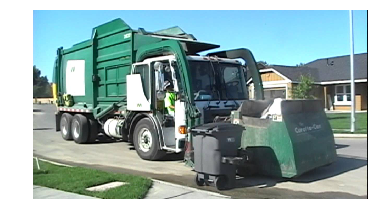

In [40]:
url = 'http://3.bp.blogspot.com/-K6UvSpMGZTU/T_V93JfmsGI/AAAAAAAAD58/rIAG54k7Qe8/s1600/Borzoi+dog+wallpapers+6.jpg'
url = 'http://www.vetbook.org/wiki/dog/images/thumb/5/5c/Lowchen.jpg/694px-Lowchen.jpg'
url = 'https://cdn.pixabay.com/photo/2016/10/15/12/01/dog-1742295_960_720.jpg'
url = 'https://www.danmurphys.com.au/media/DM/Product/750x2000/379034_0_9999_v1_m56577569837963866.jpg'
url = 'https://img-new.cgtrader.com/items/20608/heineken_beer_bottle_3d_model_fbx_lwo_lw_lws_obj_max_lxo_79aea18d-613b-46ab-b323-2bc0c3a740dc.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Official_Portrait_of_President_Reagan_1981.jpg/1200px-Official_Portrait_of_President_Reagan_1981.jpg'
url = 'http://3.bp.blogspot.com/-wRi2GBtO-Yk/T3cYy2VIgRI/AAAAAAAAB-8/Z9X6Jjc1P34/s1600/great-blue-heron.jpg'
url = 'http://assets.nydailynews.com/polopoly_fs/1.2773122.1472670685!/img/httpImage/image.jpg_gen/derivatives/article_750/nydn-2016-chevrolet-corvette-stingray-arctic-white-front-quarter-3.jpg'
url = 'http://i1.ytimg.com/vi/UxUBDJlsnjI/maxresdefault.jpg'
file = get_image(url)
predict(file, mod, synsets)
